# A Dependency Parser with deep neural network

## Creating Vocabulary from the training data
First we should read from data file. The data looks like the following
```txt
Two     NUM
of      ADP
them    PRON
were    AUX
being   AUX
run     VERB
by      ADP
2       NUM
officials       NOUN
of      ADP
the     DET
Ministry        PROPN
of      ADP
the     DET
Interior        PROPN
!       PUNCT

The     DET
MoI     PROPN
in      ADP
Iraq    PROPN
is      AUX
equivalent      ADJ
to      ADP
the     DET
US      PROPN
FBI     PROPN
,       PUNCT
so      ADV
this    PRON
would   AUX
be      VERB
like    SCONJ
having  VERB
J.      PROPN
Edgar   PROPN
Hoover  PROPN
unwittingly     ADV
employ  VERB
at      ADP
a       DET
high    ADJ
level   NOUN
members NOUN
of      ADP
the     DET
Weathermen      PROPN
bombers NOUN
back    ADV
in      ADP
the     DET
1960s   NOUN
.       PUNCT


```

In [1]:
vocabs_word_path = "data/vocabs.word"
vocabs_pos_path = "data/vocabs.pos"
vocabs_label_path = "data/vocabs.labels"
vocabs_action_path = "data/vocabs.actions"

#create string to integer mapping (because neural network libraries work with integers)
word_dict = {l.split(" ")[0]:int(l.split(" ")[1]) for l in open(vocabs_word_path, 'r').read().strip().split('\n')}
pos_dict = {l.split(" ")[0]:int(l.split(" ")[1]) for l in open(vocabs_pos_path, 'r').read().strip().split('\n')}
label_dict = {l.split(" ")[0]:int(l.split(" ")[1]) for l in open(vocabs_label_path, 'r').read().strip().split('\n')}
action_dict = {l.split(" ")[0]:int(l.split(" ")[1]) for l in open(vocabs_action_path, 'r').read().strip().split('\n')}

We define some auxiliary functions to access the words, tag feature and tag output

In [2]:
def actionid2action_str(id):
    return actions[id]

def action2id(action):
    return action_dict[action]

def label2id(label):
    return label_dict[label]

def pos2id(pos):
    return pos_dict[pos] if pos in pos_dict else 999

def word2id(word):
    return word_dict[word] if word in word_dict else word_dict['<unk>']

def num_words():
    return len(word_dict)

def num_pos():
    return len(pos_dict)

def num_labels():
    return len(label_dict)

def num_actions():
    return len(action_dict)

# Defining the network

In [3]:
#import necessary libraries
%matplotlib inline
import dynet
import random
import matplotlib.pyplot as plt
import numpy as np
import json

Steps in deep network design
1. Define the model (parameter container)
2. Define updater (e.g. SGD or ADAM) and bound it to the model
3. Define parameters (embeddings and other parameters)

In [4]:
# set values for the various parameters
trainer = 'amsgrad' # {amsgrad, adam, rmsprop, adadelta, adagrad, momentumsgd}
epochs = 10
activation = 'rectify' # {rectify, tanh, logistic}
word_embed_dim, pos_embed_dim, label_embed_dim = 96, 64, 64
minibatch_size = 1000
hidden1_dim, hidden2_dim = 500, 500
dropout = 0.3
model_path = "trained_part7.model"
model_param = {"trainer":trainer,
               "epochs":epochs,
               "activation":activation,
               "word_embed_dim":word_embed_dim,
               "pos_embed_dim":pos_embed_dim,
               "label_embed_dim":label_embed_dim,
               "minibatch_size":minibatch_size,
               "hidden1_dim":hidden1_dim,
               "hidden2_dim":hidden2_dim}

In [5]:
# first initialize a computation graph container (or model).
model = dynet.Model()

#functions to save and load the network
def load(filename):
    model.populate(filename)

def save(filename):
    model.save(filename)

# assign the algorithm for backpropagation updates.
updater = {"amsgrad":dynet.AmsgradTrainer,
           "adam":dynet.AdamTrainer,
           "rmsprop":dynet.RMSPropTrainer,
           "adadelta":dynet.AdadeltaTrainer,
           "adagrad":dynet.AdagradTrainer, 
           "momentumsgd":dynet.MomentumSGDTrainer}[trainer](model)

# assign transfer function
transfer = {"rectify":dynet.rectify, 
            "tanh":dynet.tanh,
            "logistic":dynet.logistic}[activation] 

# create embeddings for words, pos and label features.
word_embedding = model.add_lookup_parameters((num_words(), word_embed_dim))
pos_embedding = model.add_lookup_parameters((num_pos(), pos_embed_dim))
label_embedding = model.add_lookup_parameters((num_labels(), label_embed_dim))

In [6]:
# define the input dimension for the embedding layer.
# here we assume to see two words after and before and current word (meaning 5 word embeddings)
# and to see the last two predicted tags (meaning two tag embeddings)
input_dim = 20 * word_embed_dim + 20 * pos_embed_dim + 12 * label_embed_dim

# define the hidden layer 1.
hidden1_layer = model.add_parameters((hidden1_dim, input_dim))

# define the hidden layer 1 bias term and initialize it as constant 0.01.
hidden1_layer_bias = model.add_parameters(hidden1_dim, init=dynet.ConstInitializer(0.01))

# define the hidden layer 2.
hidden2_layer = model.add_parameters((hidden2_dim, hidden1_dim))

# define the hidden layer 2 bias term and initialize it as constant 0.01.
hidden2_layer_bias = model.add_parameters(hidden2_dim, init=dynet.ConstInitializer(0.01))

# define the output weight.
output_layer = model.add_parameters((num_actions(), hidden2_dim))

# define the bias vector and initialize it as constant 0.01.
output_bias = model.add_parameters(num_actions(), init=dynet.ConstInitializer(0.01))

# Implementing the Forward function


In [7]:
def forward(features):
    # extract word, pos and label ids
    word_ids = [word2id(word) for word in features[0:20]]
    pos_ids = [pos2id(pos) for pos in features[20:40]]
    label_ids = [label2id(label) for label in features[40:52]]

    # extract word embeddings and tag embeddings from features
    word_embeds = [word_embedding[wid] for wid in word_ids]
    pos_embeds = [pos_embedding[pid] if pid!=999 else dynet.zeros(pos_embed_dim) for pid in pos_ids]
    label_embeds = [label_embedding[lid] for lid in label_ids]

    # concatenating all features
    embedding_layer = dynet.concatenate(word_embeds + pos_embeds + label_embeds)
    if dropout != 0.0:
        embedding_layer = dynet.dropout(embedding_layer, dropout)

    # calculating the hidden layer 1
    # .expr() converts a parameter to a matrix expression in dynetnet (its a dynetnet-specific syntax).
    hidden1 = transfer(hidden1_layer.expr() * embedding_layer + hidden1_layer_bias.expr())
    if dropout != 0.0:
        hidden1 = dynet.dropout(hidden1, dropout)
     # calculating the hidden layer 2
    hidden2 = transfer(hidden2_layer.expr() * hidden1 + hidden1_layer_bias.expr())
    if dropout != 0.0:
        hidden2 = dynet.dropout(hidden2, dropout)

    # calculating the output layer
    output = output_layer.expr() * hidden2 + output_bias.expr()

    # return a list of outputs
    return output

# Training with backpropagation

## Reading the training data into a list

In [8]:
train_data_path = 'data/train.data'
train_data = open(train_data_path, 'r').read().strip().split('\n')
loss_values = []

def train_iter(train_data):
    losses = [] # minibatch loss vector
    random.shuffle(train_data) # shuffle the training data.

    for line in train_data:
        fields = line.strip().split(' ')
        features, label, gold_label = fields[:-1], fields[-1], action2id(fields[-1])
        result = forward(features)

        # getting loss with respect to negative log softmax function and the gold label; and appending to the minibatch losses.
        loss = dynet.pickneglogsoftmax(result, gold_label)
        losses.append(loss)

        if len(losses) >= minibatch_size:
            minibatch_loss = dynet.esum(losses) / len(losses) # now we have enough loss values to get loss for minibatch
            minibatch_loss.forward() # calling dynetnet to run forward computation for all minibatch items
            minibatch_loss_value = minibatch_loss.value() # getting float value of the loss for current minibatch

            # printing info and plotting
            loss_values.append(minibatch_loss_value)

            #if len(loss_values)%10==0: plot(loss_values)

            minibatch_loss.backward() # calling dynetnet to run backpropagation
            updater.update() # calling dynet to change parameter values with respect to current backpropagation

            # empty the loss vector and refresh the memory of dynetnet
            losses = []
            dynet.renew_cg()

    dynet.renew_cg() # there are still some minibatch items in the memory but they are smaller than the minibatch size

# Training epochs

In [9]:
def train_network():
    for i in range(epochs):
        print 'epoch', (i+1)
        train_iter(train_data)
        dynet.renew_cg()
    print 'finished training!'

In [10]:
train_network()

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
finished training!


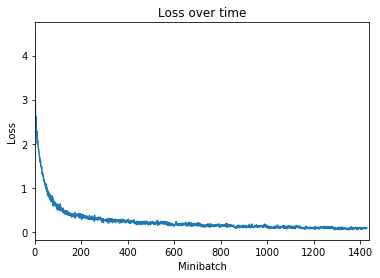

In [11]:
ax = plt.gca()
plt.title("Loss over time")
plt.xlabel("Minibatch")
plt.ylabel("Loss")
ax.set_xlim([0, len(loss_values)+10])
ax.plot(loss_values)
plt.draw()
plt.show()

In [12]:
save(model_path)
with open(model_path+".json", 'w') as fp:
    json.dump(model_param, fp)

# Parsing a file

In [ ]:
#implementing decoder
def predict(features):
    # running forward
    output = forward(features)

    # getting list value of the output
    scores = output.npvalue()

    # refresh dynet memory (computation graph)
    dynet.renew_cg()
    
    # if returning best action, get best tag id, then get the string
    best_action_id = np.argmax(scores)
    return actionid2action_str(best_action_id)
    
    """
    # if returning the score only
    return scores
    """

In [ ]:
test_file = 'data/en.pos.dev'
writer = open(test_file+'.output', 'w')
for sentence in open(test_file, 'r'):
    # get the features in a list by splitting the input by space/tab, excluding the last one
    features = sentence.strip().split()[:-1]
    action = predict(features)
    output = "\t".join(features+action)
    writer.write('\n'.join(output) + '\n\n')
writer.close()